In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sys
import os
import re
import shutil
import string

print("Python path:", sys.executable)
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Matplotlib version:", mpl.__version__)
print("Numpy version:", np.version.version)
print("Pandas version:", pd.__version__)
print("Sklearn version:", sklearn.__version__)

Python path: C:\anaconda\python.exe
Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.5.0
Matplotlib version: 3.3.4
Numpy version: 1.19.5
Pandas version: 1.2.4
Sklearn version: 0.24.1


In [2]:
# load csv
df = pd.read_csv('kaggle1.csv')
df.head(5)


,S.No.,HSCode,Commodity,Y1819,PercentShare19,Y1920P,PercentShare20,PercentGrowth,Clean Commodity
0,1,1012100,Pure-Bred Breeding Horses,0.00,0.0000,209.12,0.0001,0,Pure-Bred Breeding Horses
1,2,1012910,Horses For Polo,105.99,0.0000,72.70,0.0000,0,Horses For Polo
2,3,1012990,Horses,1683.48,0.0005,956.18,0.0003,0,Horses
3,4,1019090,Mules,2.66,0.0000,47.89,0.0000,0,Mules
4,5,1022110,Bulls For Breeding,0.00,0.0000,117.82,0.0000,0,Bulls For Breeding


In [3]:
# Preprocess the CSV
# Throw unused tables
# Add new tables if required

# see https://www.customslegaloffice.com/global/the-fundamentals-of-hs-classification/

HSCodeDescDict = {1: "Chapter 01-05: Live Animals; Animal Products", 
                  2: "Chapter 06-15: Vegetable Products",
                  3: "Chapter 16-24: Food stuffs",
                  4: "Chapter 25-27: Mineral Products",
                  5: "Chapter 28-38: Chemicals && Allied Industries",
                  6: "Chapter 39-40: Plastic or Rubbers",
                  7: "Chapter 41-43: Raw Hides, Skins, Leather & Furs",
                  8: "Chapter 44-49: Wood & Wood Products",
                  9: "Chapter 50-63: Textiles",
                  10: "Chapter 64-67: Footwear / Headgear",
                  11: "Chapter 68-71: Stone / Glass",
                  12: "Chapter 72-83: Metals",
                  13: "Chapter 84-85: Machinery / Electrical",
                  14: "Chapter 86-89: Transportation",
                  15: "Chapter 90-97: Miscellaneous",
                  16: "Chapter 98-99: Service"}

def HSCodeDescription(row):
  section = int(row['HSCodeChapter'])
  if 1 <= section and section < 6:
    return HSCodeDescDict[1]
  elif 6 <= section and section < 16:
    return HSCodeDescDict[2]
  elif 16 <= section and section < 25:
    return HSCodeDescDict[3]
  elif 25 <= section and section < 28:
    return HSCodeDescDict[4]
  elif 28 <= section and section < 39:
    return HSCodeDescDict[5]
  elif 39 <= section and section < 41:
    return HSCodeDescDict[6]
  elif 41 <= section and section < 44:
    return HSCodeDescDict[7]
  elif 44 <= section and section < 50:
    return HSCodeDescDict[8]
  elif 50 <= section and section < 64:
    return HSCodeDescDict[9]
  elif 64 <= section and section < 68:
    return HSCodeDescDict[10]
  elif 68 <= section and section < 72:
    return HSCodeDescDict[11]
  elif 72 <= section and section < 84:
    return HSCodeDescDict[12]
  elif 84 <= section and section < 86:
    return HSCodeDescDict[13]
  elif 86 <= section and section < 90:
    return HSCodeDescDict[14]
  elif 90 <= section and section < 98:
    return HSCodeDescDict[15]
  elif 98 <= section and section < 100:
    return HSCodeDescDict[16]
  else:
    return "Unknown"

from io import StringIO
col = ['Commodity', 'HSCode']
df = df[col]
df = df[pd.notnull(df['HSCode'])]
#df['HSCodeType'] = type(df['HSCode'])

df['HSCodeChapter'] = df['HSCode'].astype(str).str[:-6]
df['HSCodeChapterDetail'] = df['HSCode'].astype(str).str[-6:]
df['HSCodeChapterDescription'] = df.apply(lambda row: HSCodeDescription(row), axis=1)
df.head(2000)


#sectiontry = int(df.iloc[3995]['HSCodeChapter'])
#if(39 <= sectiontry and sectiontry < 41 ):
#  print("success")
#else:
#  print("fail")

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products
...,...,...,...,...,...
1995,Other Salts Of Formic Acid,29151290,29,151290,Chapter 28-38: Chemicals && Allied Industries
1996,Esters Of Formic Acid,29151300,29,151300,Chapter 28-38: Chemicals && Allied Industries
1997,Acetic Acid,29152100,29,152100,Chapter 28-38: Chemicals && Allied Industries
1998,Acetic Anhydride,29152400,29,152400,Chapter 28-38: Chemicals && Allied Industries


In [4]:

df['HSCodeChapterId'] = df['HSCodeChapterDescription'].factorize()[0]
category_id_df = df[['HSCodeChapterDescription', 'HSCodeChapterId']].drop_duplicates().sort_values('HSCodeChapterId')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['HSCodeChapterId', 'HSCodeChapterDescription']].values)
df.head(7000)

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0
...,...,...,...,...,...,...
6995,Bright Bars-Chromium Type,72210011,72,210011,Chapter 72-83: Metals,11
6996,Brght Bars Nckl Chrm Astntc Type,72210012,72,210012,Chapter 72-83: Metals,11
6997,Others,72210019,72,210019,Chapter 72-83: Metals,11
6998,Brght Bars N.E.S.,72210090,72,210090,Chapter 72-83: Metals,11


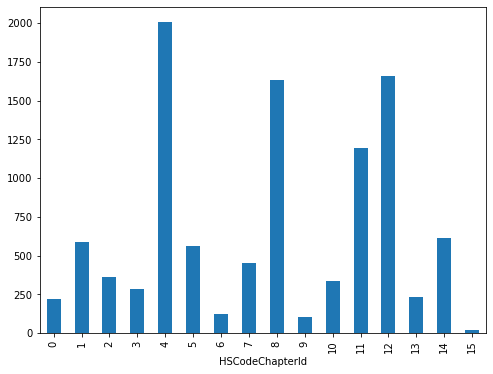

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('HSCodeChapterId').HSCode.count().plot.bar(ylim=0)
plt.show()

In [6]:
# This is incorrect... using TF-IDF is not the way (because it uses frequency of certain words to determine category)
# we need to somehow use Short text to classify...

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Commodity).toarray()
labels = df.HSCodeChapterId
features.shape

(10380, 2417)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Commodity, HSCodeChapterId in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == HSCodeChapterId)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Commodity))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Chapter 01-05: Live Animals; Animal Products':
  . Most correlated unigrams:
. fillets
. frozen
  . Most correlated bigrams:
. frozen fillets
. fresh chilled
# 'Chapter 06-15: Vegetable Products':
  . Most correlated unigrams:
. dried
. seeds
  . Most correlated bigrams:
. edble grade
. crushed ground
# 'Chapter 16-24: Food stuffs':
  . Most correlated unigrams:
. holding
. tobacco
  . Most correlated bigrams:
. containers holding
. holding ltr
# 'Chapter 25-27: Mineral Products':
  . Most correlated unigrams:
. calcined
. ores
  . Most correlated bigrams:
. manganese ore
. ores concentrates
# 'Chapter 28-38: Chemicals && Allied Industries':
  . Most correlated unigrams:
. salts
. acid
  . Most correlated bigrams:
. acid salts
. non azo
# 'Chapter 39-40: Plastic or Rubbers':
  . Most correlated unigrams:
. resins
. shts
  . Most correlated bigrams:
. rigid plain
. pltes shts
# 'Chapter 41-43: Raw Hides, Skins, Leather & Furs':
  . Most correlated unigrams:
. leather
. skins
  . Most

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Commodity'], df['HSCodeChapterId'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
print(clf.predict(count_vect.transform(['Mules'])))

[4]


In [10]:
df.head(4000)

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0
...,...,...,...,...,...,...
3995,Rubber Ring(O-Ring),40169320,40,169320,Chapter 39-40: Plastic or Rubbers,5
3996,"Rubber Seals(Oil Seals,Etc)",40169330,40,169330,Chapter 39-40: Plastic or Rubbers,5
3997,Gaskets,40169340,40,169340,Chapter 39-40: Plastic or Rubbers,5
3998,Washers,40169350,40,169350,Chapter 39-40: Plastic or Rubbers,5


In [19]:

# add columns to "tokenize" the words
# Besides removing "stop" and "junk" words, we may wanna try to correct the spelling based on some corpus of vocab
# https://towardsdatascience.com/essential-text-correction-process-for-nlp-tasks-f731a025fcc3

# may need to consider entire dictionary for the bag of words?
# how to handle new words?
# https://stats.stackexchange.com/questions/198785/how-to-asses-the-optimal-bag-of-words-vector-size

import nltk

ignore = ['0C', '0F', '0Il', '0Leyl', '0Thers', '0Ther', '0Thr', '10000Kva'];
    
def tokenizeAndRemoveStopWords(row):
  tokenizerWithoutPunctuation = nltk.RegexpTokenizer(r"\w+")
  tokens = tokenizerWithoutPunctuation.tokenize(row['Commodity'])
  for i, s in enumerate(tokens):
    if s.isnumeric() or s in ignore:
      tokens[i] = "0"
    else:
      tokens[i] = s
      # use this to find out what index each vocab is found in
      #tokens[i] = s + str(row.name)
  return tokens 

df['tokens'] = df.apply(lambda row:  tokenizeAndRemoveStopWords(row), axis=1)

df.head(400)


,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId,tokens
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0,"[Pure, Bred, Breeding, Horses]"
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0,"[Horses, For, Polo]"
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0,[Horses]
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0,[Mules]
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0,"[Bulls, For, Breeding]"
...,...,...,...,...,...,...,...
395,Tamarind Dried,8134010,8,134010,Chapter 06-15: Vegetable Products,1,"[Tamarind, Dried]"
396,Others Fruit Dried (Excldng Tamarind And Singo...,8134090,8,134090,Chapter 06-15: Vegetable Products,1,"[Others, Fruit, Dried, Excldng, Tamarind, And,..."
397,Mixtures Of Nuts,8135010,8,135010,Chapter 06-15: Vegetable Products,1,"[Mixtures, Of, Nuts]"
398,"Peel Of Citrs Fruit/Melns(Incl Wtrmelns), Frsh...",8140000,8,140000,Chapter 06-15: Vegetable Products,1,"[Peel, Of, Citrs, Fruit, Melns, Incl, Wtrmelns..."


In [20]:
# TODO: import the tokens of each chapter the Word2Vec for that chapter..

# websites to refer:
# https://towardsdatascience.com/multiclass-classification-with-word-bags-and-word-sequences-4fffd4d62e0c
# https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/
from gensim.models import word2vec

arr = df['tokens'].to_numpy()
print(arr)
print(arr.shape)
print(type(arr))

#tokenize
vocabs = []

for x in range(0, arr.shape[0]):
    vocabs.extend(arr[x])
    
# sort it
vocabs = sorted(list(set(vocabs)))
print(len(vocabs))
print(vocabs)





        
    
    
      

[list(['Pure', 'Bred', 'Breeding', 'Horses'])
 list(['Horses', 'For', 'Polo']) list(['Horses']) ...
 list(['Special', 'Transactions', 'N', 'E', 'S'])
 list(['Unspecified', 'Items']) list(['Suppressed', 'Commodity'])]
(10380,)
<class 'numpy.ndarray'>
9486
['0', '0On', '0Ptical', '0R', '0Re', '1000Cc', '1000Kw', '1000V', '100Mm', '105Cm', '105Mm', '10Kg', '10Mm', '11Kv', '11Mm', '132Kv', '14Mm', '15000Kva', '1500Cc', '1500Ccprincipally', '1500Kva', '150Cm', '150G', '150Gm', '150Gsm', '150Mm', '150Watt', '16Kva', '16Mm', '1800Cc', '185G', '198Cm', '1J', '1Mm', '2000Kva', '2000Kw', '200M', '20Cm', '225G', '22X36', '240Cm', '2500Cc', '25Cm', '25G', '2G', '2R', '3000Cc', '3000Ccprincipally', '300Cc', '300L', '30Cm', '30M', '35Mm', '375Kva', '3920Of', '3D', '3Kg', '3M2', '3Methoxy', '3Mm', '40Lts', '45T', '46Mm', '4Inalyl', '4Methyl', '4Mm', '5000Kva', '500Cc', '500Gm', '50Cc', '50Mm', '56Mm', '5Kv', '5Mm', '5X10', '600Mm', '60Cm', '60Mm', '610Mm', '66Kv', '6M', '6Mm', '70G', '70Mmbut', '75Cm

In [22]:
import numpy

print(arr.shape[0])

vocab0 = []
vocab0.extend(arr[0])
print(vocab0)

bag_vector = numpy.zeros(len(vocabs))
print(bag_vector.shape)
print(bag_vector)
for vocab0word in vocab0:
  for i,word in enumerate(vocabs):
    if word == vocab0word:
      bag_vector[i] += 1  
      print(i)
    
print(bag_vector)

print(vocabs[6846])
print(vocabs[1102])
print(vocabs[1104])
print(vocabs[4155])

10380
['Pure', 'Bred', 'Breeding', 'Horses']
(9486,)
[0. 0. 0. ... 0. 0. 0.]
6846
1102
1104
4155
[0. 0. 0. ... 0. 0. 0.]
Pure
Bred
Breeding
Horses


In [ ]:
# our above code actually can be replaced by (to try):

#from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(allsentences)print(X.toarray())



In [ ]:
#https://www.tensorflow.org/tutorials/text/word2vec

# word2vec contains either Continuous Bag of words (predict the middle word based on surrounding context words)
#    or Continuous Skip-gram model (predicts words within certain range before and after current word in the same sentence)
#    so i dont think word2vec is what we want. We are not training using description, and then try to guess what words are 
#    to be generrated / described by those descriptions.. 

# Hence we need to vectorize the description instead to a vocab..



w2v_model = word2vec.Word2Vec(arr, min_count=1, vector_size=200, sg=0)
w2v_weight = w2v_model.wv.vectors

pd.DataFrame(w2v_weight)

In [ ]:
w2v_model.wv.most_similar("Horses")

In [ ]:
hscode_y = df['HSCode'].to_numpy()
pd.DataFrame(hscode_y)

In [ ]:
#def one_hot(y):
#    y = y.astype(dtype='int64')
#    label_binarizer = sklearn.preprocessing.LabelBinarizer()
#    label_binarizer.fit(range(max(y) + 1))
#    one_hot_y = label_binarizer.transform(y)
#    return one_hot_y

#hscode_y_one_hot = one_hot(hscode_y)
#pd.DataFrame(hscode_y_one_hot)